# Tidy Data

> Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

If there's one maxim I can impart it's that your tools shouldn't get in the way of your analysis. Your problem is already difficult enough.

## The Rules

In a tidy dataset...

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We'll cover a few methods that help you get there.

Based on [this](http://stackoverflow.com/questions/22695680/python-pandas-timedelta-specific-rows) StackOverflow question.

**How many days of rest did each team get between each game?**

In [28]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 10
%matplotlib inline

In [1]:
tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2015_games.html")
games = tables[0]
games.to_csv('data/games.csv', index=False)

In [29]:
games = pd.read_csv('data/games.csv')

games.columns = ['date', '_', 'away_team', 'away_points', 'home_team', 'home_points', 'n_ot', 'notes']
games = games.drop(['_', 'notes'], axis='columns')
games['date'] = pd.to_datetime(games.date)
games['n_ot'] = (games.n_ot.replace((np.nan, 'OT'), ('0', '1'))
                      .str.extract('(\d)')
                      .astype(int))
games.index.name = 'game_id'
games = games.set_index('date', append=True)

games.to_csv('data/tidy_date_games.csv', index=False)
games.head()

,,away_team,away_points,home_team,home_points,n_ot
game_id,date,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,0
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,0
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,0
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,0
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,1


Whether or not your dataset is tidy depends on your question. Given our question, what is an observation?

<p style="color: white;a:hover">test</p>

Is `games` a tidy dataset, given our question? No, we have multiple observations (teams) per row.

In [36]:
m = pd.melt(games.reset_index(),
            id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
            value_name='team').sort('date')

In [37]:
m.head()

,game_id,date,variable,team
0,0,2014-10-28,away_team,Houston Rockets
1,1,2014-10-28,away_team,Orlando Magic
2,2,2014-10-28,away_team,Dallas Mavericks
1231,1,2014-10-28,home_team,New Orleans Pelicans
1232,2,2014-10-28,home_team,San Antonio Spurs


Now, getting the answer is trivial: group by team and diff `date`.

In [43]:
m.groupby('team').date.diff().dt.days

0      NaN
1      NaN
2      NaN
1231   NaN
1232   NaN
        ..
1218     1
1217     2
1216     2
2458     2
2459     1
dtype: float64

In [44]:
m['rest'] = m.groupby('team').date.diff().dt.days
m.dropna().head()

,game_id,date,variable,team,rest
10,10,2014-10-29,away_team,Los Angeles Lakers,1
14,14,2014-10-29,away_team,Houston Rockets,1
1248,18,2014-10-30,home_team,Minnesota Timberwolves,1
16,16,2014-10-30,away_team,Utah Jazz,1
1249,19,2014-10-30,home_team,Orlando Magic,2


In [45]:
un = pd.pivot_table(m, values='rest', index=['game_id', 'date'], columns='variable').rename(
    columns={'away_team': 'away_rest', 'home_team': 'home_rest'}
)

In [46]:
un.dropna().head()

,variable,away_rest,home_rest
game_id,date,,
16,2014-10-30,1,2
18,2014-10-30,1,1
19,2014-10-30,1,2
20,2014-10-31,1,2
21,2014-10-31,2,2


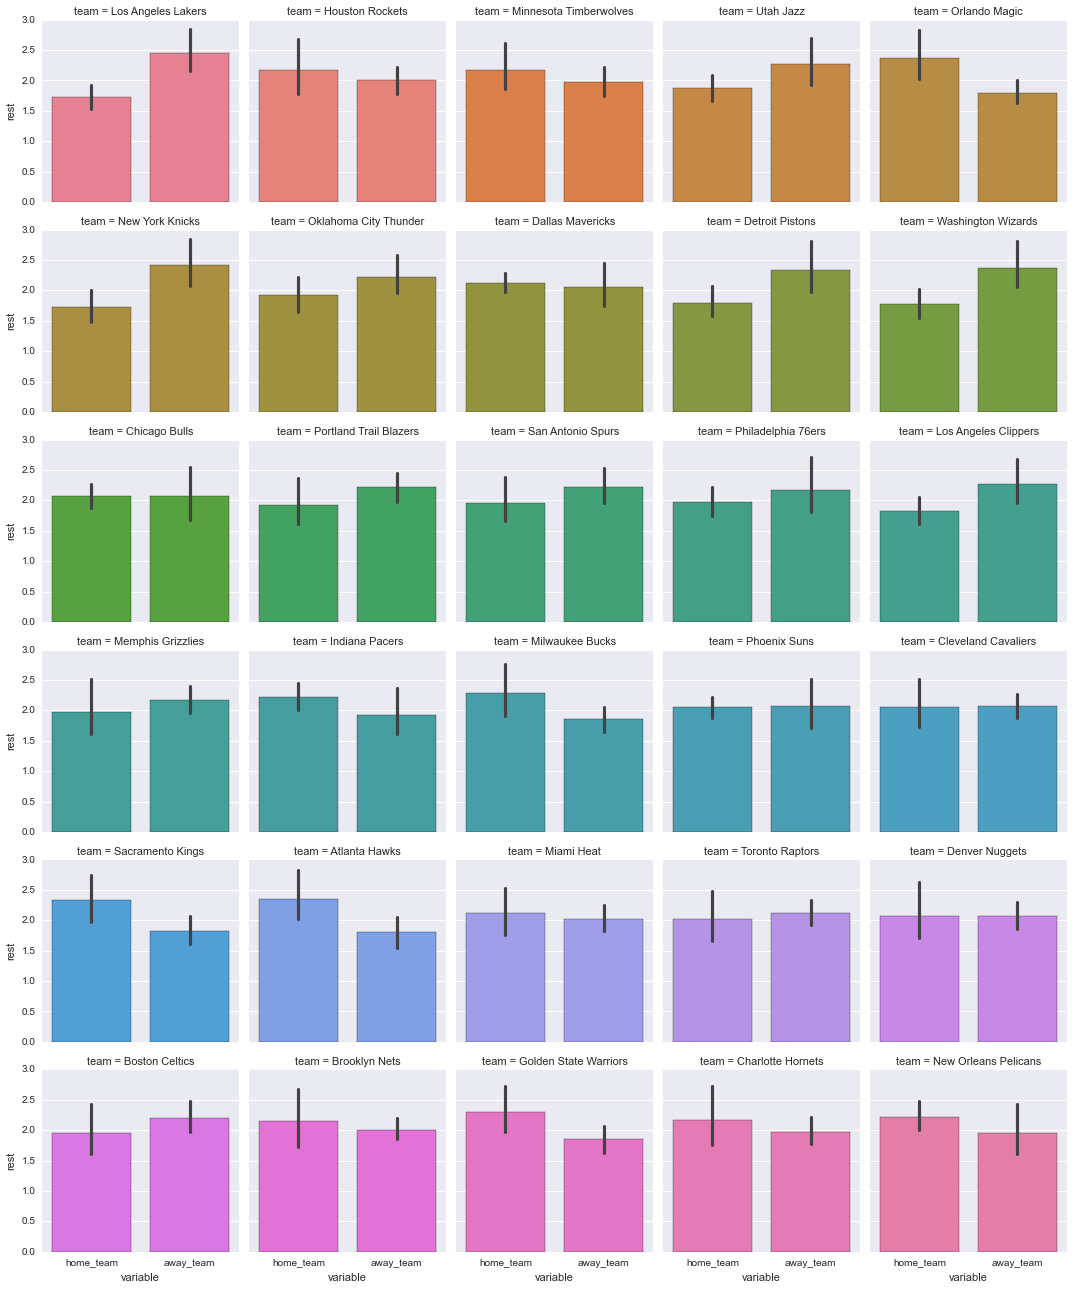

In [47]:
g = sns.FacetGrid(data=m.dropna(), col='team', col_wrap=5, hue='team')
g.map(sns.barplot, "variable", "rest")